In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fmin_cg, minimize
c = 2.99792458e8   # m/s

In [2]:
def doppler(v):
    frac = (1. - v/c) / (1. + v/c)
    return np.sqrt(frac)
        
def state(xs, xps, yps):
    # returns a, b such that ys = a * xs + b
    yps = np.concatenate((yps, [yps[-1]]), axis=0) # hack for end of grid
    xps = np.concatenate((xps, [xps[-1]+1.]), axis=0) # hack for end of grid
    mps = np.searchsorted(xps, xs, side='left')
    yps = np.concatenate(([yps[0]], yps), axis=0) # hack for end of grid
    xps = np.concatenate(([xps[0]-1.], xps), axis=0) # hack for end of grid
    ehs = (yps[mps+1] - yps[mps])/(xps[mps+1] - xps[mps])
    bes = yps[mps] - ehs * xps[mps]
    return ehs, bes
    
def P(ehs, bes, xs):
    return ehs * xs + bes
    
def dPdx(ehs):
    return ehs # lol
    
def Pdot(lnlambdas, lnlambdaps, lnfluxps, v):
    if v.ndim == 0:
        N = 1
    else:
        N = len(v)
    M = len(lnlambdas)
    lnlambdas_shifted = np.tile(lnlambdas, (N,1)) + np.tile(np.log(doppler(v)), (M,1)).T # N x M
    ehs, bes = state(lnlambdas_shifted, lnlambdaps, lnfluxps)
    return P(ehs, bes, lnlambdas_shifted) # this is lnfluxs

The following is code copied from EPRV/fakedata.py to generate a realistic fake spectrum:

In [3]:
def oned_gaussian(xs, mm, sig):
    return np.exp(-0.5 * (xs - mm) ** 2 / sig ** 2) / np.sqrt(2. * np.pi * sig)

def make_synth(rv, xs, ds, ms, sigs):
    """
    `rv`: radial velocity in m/s (or same units as `c` above
    `xs`: `[M]` array of wavelength values
    `ds`: depths at line centers
    `ms`: locations of the line centers in rest wavelength
    `sigs`: Gaussian sigmas of lines
    """
    synths = np.ones_like(xs)
    for d, m, sig in zip(ds, ms, sigs):
        synths *= np.exp(d *
            oned_gaussian(xs * doppler(rv), m, sig))
    return synths

def make_data(N, xs, ds, ms, sigs):
    """
    `N`: number of spectra to make
    `xs`: `[M]` array of wavelength values
    `ds`: depth-like parameters for lines
    `ms`: locations of the line centers in rest wavelength
    `sigs`: Gaussian sigmas of lines
    """
    np.random.seed(2361794231)
    M = len(xs)
    data = np.zeros((N, M))
    ivars = np.zeros((N, M))
    rvs = 30000. * np.random.uniform(-1., 1., size=N) # 30 km/s bc Earth ; MAGIC
    for n, rv in enumerate(rvs):
        ivars[n, :] = 10000. # s/n = 100 ; MAGIC
        data[n, :] = make_synth(rv, xs, ds, ms, sigs)
        data[n, :] += np.random.normal(size=M) / np.sqrt(ivars[n, :])
    return data, ivars, rvs

In [4]:
fwhms = [0.1077, 0.1113, 0.1044, 0.1083, 0.1364, 0.1, 0.1281,
                    0.1212, 0.1292, 0.1526, 0.1575, 0.1879] # FWHM of Gaussian fit to line (A)
sigs = np.asarray(fwhms) / 2. / np.sqrt(2. * np.log(2.)) # Gaussian sigma (A)
ms = [4997.967, 4998.228, 4998.543, 4999.116, 4999.508, 5000.206, 5000.348,
                5000.734, 5000.991, 5001.229, 5001.483, 5001.87] # line center (A)
ds = [-0.113524, -0.533461, -0.030569, -0.351709, -0.792123, -0.234712, -0.610711,
                -0.123613, -0.421898, -0.072386, -0.147218, -0.757536] # depth of line center (normalized flux)
ws = np.ones_like(ds) # dimensionless weights
dx = 0.01 # A
xs = np.arange(4998. + 0.5 * dx, 5002., dx) # A
        
N = 16
data, ivars, true_rvs = make_data(N, xs, ds, ms, sigs)
data = np.log(data)
data_xs = np.log(xs)

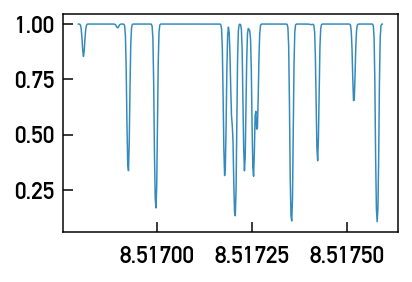

In [5]:
def add_tellurics(xs, all_data, true_rvs, lambdas, strengths, dx):
    N, M = np.shape(all_data)
    tellurics = np.ones_like(xs)
    for ll, s in zip(lambdas, strengths):
        tellurics *= np.exp(-s * oned_gaussian(xs, ll, dx))
    plt.plot(xs, tellurics)
    all_data *= np.repeat([tellurics,],N,axis=0)
    return all_data

n_tellurics = 16 # magic
telluric_sig = 3.e-6 # magic
telluric_xs = np.random.uniform(data_xs[0], data_xs[-1], n_tellurics)
strengths = 0.01 * np.random.uniform(size = n_tellurics) ** 2. # magic numbers
all_data = np.exp(data)
all_data = add_tellurics(data_xs, all_data, true_rvs, telluric_xs, strengths, telluric_sig)
data = np.log(all_data)

First step: generate some approximate models of the star and the tellurics using first-guess RVs.

In [6]:
def make_template(all_data, rvs, xs, dx):
    """
    `all_data`: `[N, M]` array of pixels
    `rvs`: `[N]` array of RVs
    `xs`: `[M]` array of wavelength values
    `dx`: linear spacing desired for template wavelength grid (A)
    """
    (N,M) = np.shape(all_data)
    all_xs = np.empty_like(all_data)
    for i in range(N):
        all_xs[i,:] = xs + np.log(doppler(rvs[i])) # shift to rest frame
    all_data, all_xs = np.ravel(all_data), np.ravel(all_xs)
    tiny = 10.
    template_xs = np.arange(min(all_xs)-tiny*dx, max(all_xs)+tiny*dx, dx)
    template_ys = np.nan + np.zeros_like(template_xs)
    for i,t in enumerate(template_xs):
        ind = (all_xs >= t-dx/2.) & (all_xs < t+dx/2.)
        if np.sum(ind) > 0:
            template_ys[i] = np.nanmedian(all_data[ind])
    ind_nan = np.isnan(template_ys)
    template_ys[ind_nan] = np.interp(template_xs[ind_nan], template_xs[~ind_nan], template_ys[~ind_nan])
    return template_xs, template_ys

def subtract_template(data_xs, data, model_xs_t, model_ys_t, rvs_t):
    (N,M) = np.shape(data)
    data_sub = np.copy(data)
    for n,v in enumerate(rvs_t):
        model_ys_t_shifted = Pdot(data_xs, model_xs_t, model_ys_t, v)
        data_sub[n,:] -= np.ravel(model_ys_t_shifted)
        if n == 0:
            plt.plot(data_xs, data[n,:], color='k')
            plt.plot(data_xs, data_sub[n,:], color='blue')
            plt.plot(data_xs, np.ravel(model_ys_t_shifted), color='red')
    return data_sub

In [7]:
x0_star = true_rvs + np.random.normal(0., 100., N)
x0_t = np.zeros(N)
model_xs_star, model_ys_star = make_template(data, x0_star, data_xs, np.log(6000.01) - np.log(6000.))
model_xs_t, model_ys_t = make_template(data, x0_t, data_xs, np.log(6000.01) - np.log(6000.))

In [8]:
def chisq_star(rvs_star, rvs_t, data_xs, data, ivars, model_xs_star, model_ys_star, model_xs_t, model_ys_t):
    pd_star = Pdot(data_xs, model_xs_star, model_ys_star, rvs_star)
    pd_t = Pdot(data_xs, model_xs_t, model_ys_t, rvs_t)
    pd = pd_star + pd_t
    return np.sum((data - pd)**2 * ivars)

def chisq_t(rvs_t, rvs_star, data_xs, data, ivars, model_xs_star, model_ys_star, model_xs_t, model_ys_t):
    pd_star = Pdot(data_xs, model_xs_star, model_ys_star, rvs_star)
    pd_t = Pdot(data_xs, model_xs_t, model_ys_t, rvs_t)
    pd = pd_star + pd_t
    return np.sum((data - pd)**2 * ivars)


In [9]:
soln_star =  minimize(chisq_star, x0_star, args=(x0_t, data_xs, data, ivars, model_xs_star, model_ys_star, model_xs_t, model_ys_t),
                     method='BFGS', options={'disp':True, 'gtol':1.e-2, 'eps':1.5e-5})['x']
soln_t =  minimize(chisq_t, x0_t, args=(soln_star, data_xs, data, ivars, model_xs_star, model_ys_star, model_xs_t, model_ys_t),
                     method='BFGS', options={'disp':True, 'gtol':1.e-2, 'eps':1.5e-5})['x']

x0_star = soln_star
x0_t = soln_t
print np.std(x0_star - true_rvs)
print np.std(x0_t)

         Current function value: 2049912.679328
         Iterations: 46
         Function evaluations: 1866
         Gradient evaluations: 103
         Current function value: 2048798.795726
         Iterations: 77
         Function evaluations: 3162
         Gradient evaluations: 175
282.763600401
12.8116901148


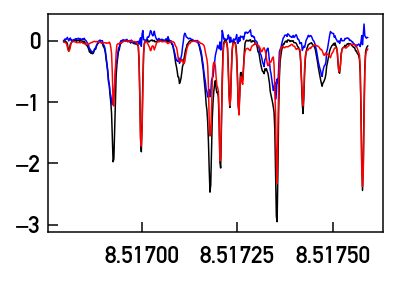

In [10]:
data_star = subtract_template(data_xs, data, model_xs_t, model_ys_t, x0_t)

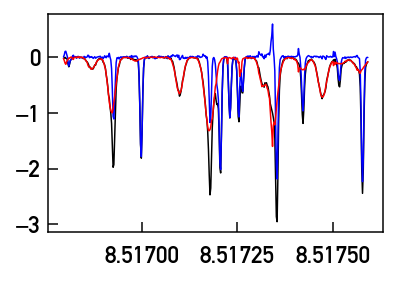

In [11]:
data_t = subtract_template(data_xs, data, model_xs_star, model_ys_star, x0_star)

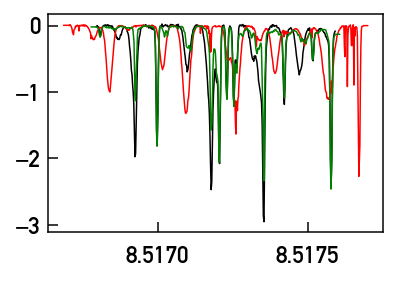

In [12]:
plt.plot(data_xs, data[0,:], color='black')
plt.plot(model_xs_star, model_ys_star, color='red')
plt.plot(model_xs_t, model_ys_t, color='green')

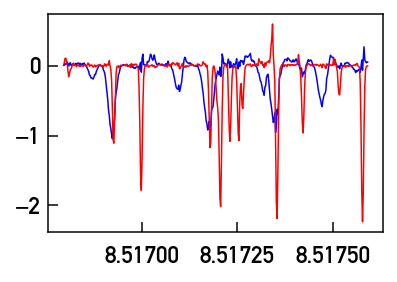

In [13]:
plt.plot(data_xs, data_star[0,:], color='blue')
plt.plot(data_xs, data_t[0,:], color='red')

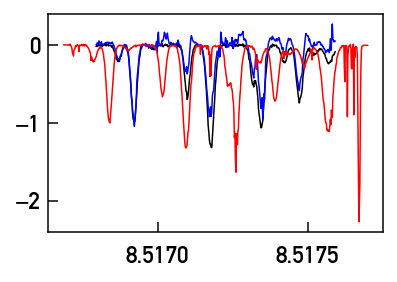

In [14]:
true_star = np.log(make_data(N, xs, ds, ms, sigs)[0])
plt.plot(data_xs, true_star[0,:], color='k')
plt.plot(data_xs, data_star[0,:], color='blue')
plt.plot(model_xs_star, model_ys_star, color='red')

Next: use the template-subtracted data to get better RVs for star and template

In [15]:
soln_star =  minimize(chisq_star, x0_star, args=(x0_t, data_xs, data, ivars, model_xs_star, model_ys_star, model_xs_t, model_ys_t),
                     method='BFGS', options={'disp':True, 'gtol':1.e-2, 'eps':1.5e-5})['x']
soln_t =  minimize(chisq_t, x0_t, args=(soln_star, data_xs, data, ivars, model_xs_star, model_ys_star, model_xs_t, model_ys_t),
                     method='BFGS', options={'disp':True, 'gtol':1.e-2, 'eps':1.5e-5})['x']


print np.std(soln_star - true_rvs)
print np.std(soln_t)

         Current function value: 2048783.502272
         Iterations: 25
         Function evaluations: 1271
         Gradient evaluations: 70
         Current function value: 2048783.501229
         Iterations: 17
         Function evaluations: 1341
         Gradient evaluations: 74
283.169532039
12.8116286918


and repeat:

         Current function value: 818704.006061
         Iterations: 43
         Function evaluations: 2100
         Gradient evaluations: 116
         Current function value: 817360.998528
         Iterations: 19
         Function evaluations: 570
         Gradient evaluations: 31
iter 0: star std = 66.94, telluric std = 5.51
         Current function value: 676572.108841
         Iterations: 14
         Function evaluations: 1053
         Gradient evaluations: 58
         Current function value: 674982.794384
         Iterations: 70
         Function evaluations: 2693
         Gradient evaluations: 149
iter 1: star std = 67.77, telluric std = 1.65
         Current function value: 656256.841669
         Iterations: 57
         Function evaluations: 2478
         Gradient evaluations: 137
         Current function value: 654571.839229
         Iterations: 23
         Function evaluations: 1181
         Gradient evaluations: 65
iter 2: star std = 40.94, telluric std = 3.74
         Curre

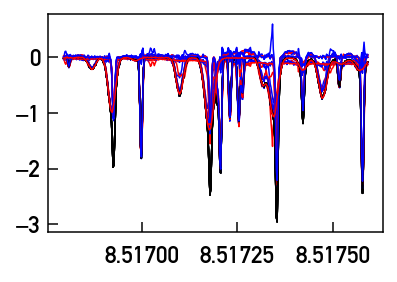

In [16]:
for n in range(5):
    x0_star = soln_star
    x0_t = soln_t

    data_star = subtract_template(data_xs, data, model_xs_t, model_ys_t, x0_t)
    data_t = subtract_template(data_xs, data, model_xs_star, model_ys_star, x0_star)

    model_xs_star, model_ys_star = make_template(data_star, x0_star, data_xs, np.log(6000.01) - np.log(6000.))
    model_xs_t, model_ys_t = make_template(data_t, x0_t, data_xs, np.log(6000.01) - np.log(6000.))

    soln_star =  minimize(chisq_star, x0_star, args=(x0_t, data_xs, data, ivars, model_xs_star, model_ys_star, model_xs_t, model_ys_t),
                     method='BFGS', options={'disp':True, 'gtol':1.e-2, 'eps':1.5e-5})['x']
    soln_t =  minimize(chisq_t, x0_t, args=(soln_star, data_xs, data, ivars, model_xs_star, model_ys_star, model_xs_t, model_ys_t),
                     method='BFGS', options={'disp':True, 'gtol':1.e-2, 'eps':1.5e-5})['x']

    print "iter {0}: star std = {1:.2f}, telluric std = {2:.2f}".format(n, np.std(soln_star - true_rvs), np.std(soln_t))

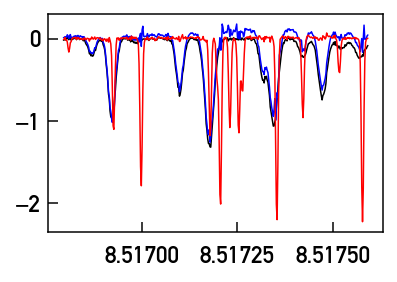

In [21]:
true_star = np.log(make_data(N, xs, ds, ms, sigs)[0])
plt.plot(data_xs, true_star[0,:], color='k')
plt.plot(data_xs, data_star[0,:], color='blue')
plt.plot(data_xs, data_t[0,:], color='red')

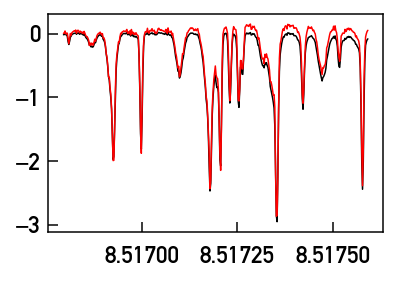

In [22]:
plt.plot(data_xs, data[0,:], color='k')
plt.plot(data_xs, data_star[0,:] + data_t[0,:], color='red')

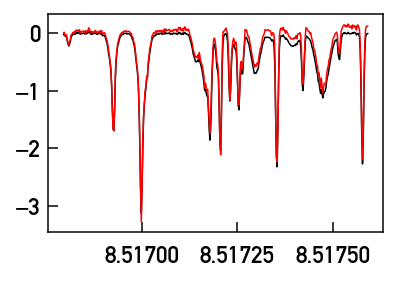

In [23]:
plt.plot(data_xs, data[10,:], color='k')
plt.plot(data_xs, data_star[10,:] + data_t[10,:], color='red')